**Imports**

In [409]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import  LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

**Reading the Data...**

In [410]:
df = pd.read_csv('data.csv')
df.head()

,message,fingers,tail,species
0,pluvia arbor aquos,4,no,Aquari
1,cosmix xeno nebuz odbitaz,5,yes,Zorblax
2,solarix glixx novum galaxum quasar,5,yes,Zorblax
3,arbor insectus pesros ekos dootix nimbus,2,yes,Florian
4,mermax drakos lorix epikoz deftax,4,no,Faerix


**Splittind the data into training set and test set..**

In [411]:
X = df[['message','fingers','tail']]
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

**Feature Enginerring**

In [412]:
tfidf = TfidfVectorizer(max_features=1000)
onehot = ColumnTransformer([('fingers_tail', OneHotEncoder(handle_unknown='ignore'), ['fingers','tail'])], remainder='passthrough')

In [420]:
param_grid = {
    'features__tfidf__max_features': [500, 1000, 1500],      
    'features__tfidf__ngram_range': [(1, 1), (1, 2)],        
    'features__tfidf__max_df': [0.7, 0.9],                   
    'features__tfidf__min_df': [0.01, 0.05],                 
    'features__tfidf__use_idf': [True, False],              
    'clf__C': [0.1, 1, 10, 100, 1000],   
    'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10], 
}

**Writing pipelines for model..**

In [413]:
pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('tfidf', tfidf, 'message'),
        ('onehot', onehot, ['fingers', 'tail'])
    ])),
    ('clf', SVC(kernel='rbf'))
])
# pipeline.fit(X_train, y_train)
pipeline = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=1000),
                                                  'message'),
                                                 ('onehot',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('fingers_tail',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['fingers',
                                                                                    'tail'])]),
                                                  ['fingers', 'tail'])])),
                ('clf', SVC())])

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

**Model Prediction**

In [414]:
y_pred_train = pipeline.predict(X_train)
y_pred_train_accuracy = accuracy_score(y_train, y_pred_train)


In [415]:
y_pred_train_accuracy

0.8925

*Testing and Evaluation of test set..*


In [416]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.83


**Visualisng the confusion matrix...**

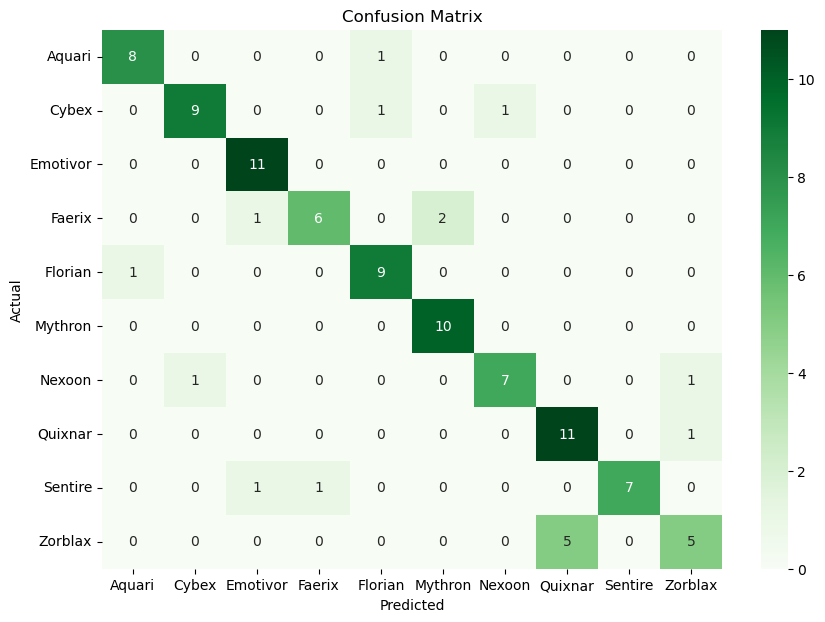

In [417]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [418]:
print(conf_matrix)



[[ 8  0  0  0  1  0  0  0  0  0]
 [ 0  9  0  0  1  0  1  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  1  6  0  2  0  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  1  0  0  0  0  7  0  0  1]
 [ 0  0  0  0  0  0  0 11  0  1]
 [ 0  0  1  1  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  5  0  5]]


In [419]:
test = pd.read_csv('test.csv')
predictions = pipeline.predict(test)
test['species'] = predictions
test.to_excel('result.xlsx', index=False)